# Readme
The code is a Jupyter Notebook with Python3 code. To run the code, you will need the Collections, pandas, and matplotlib libraries. Analysis is done using pandas' Series and Dataframes, while plotting it done with matplotlib.

There are no special instructions for running the code. It's a standard Jupyter notebook.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [13]:

netflow_df = pd.read_csv('netflow.csv')
split_src_ids = netflow_df["Src IP addr"].apply(lambda x: x.split('.'))
split_dst_ids = netflow_df["Dst IP addr"].apply(lambda x: x.split('.'))
netflow_df["src_ip_prefix"] = split_src_ids.apply(lambda x: '.'.join(x[0:2]))
netflow_df["dst_ip_prefix"] = split_dst_ids.apply(lambda x: '.'.join(x[0:2]))

# 1.1
My first observation is that nearly all packets are less than 1,000 bytes long. The second observation is that UDP packets tend to be smaller, and have almost no outliers larger than 1,000 bytes. More than half of the packets in each protocol have sizes of less than 100.

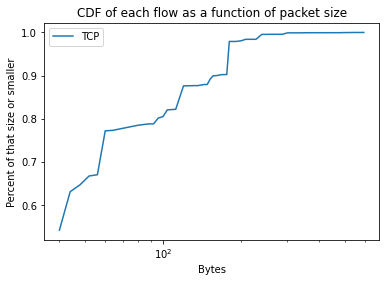

In [32]:
pdf = netflow_df.groupby("Protocol")['Bytes'].value_counts()

udp_cdf = pdf["UDP"].sort_index().cumsum() / pdf["UDP"].sort_index().sum()
tcp_cdf = pdf["TCP"].sort_index().cumsum() / pdf["TCP"].sort_index().sum()

plt.plot(tcp_cdf.index, tcp_cdf.values)
plt.xlabel('Bytes')
plt.ylabel('Percent of that size or smaller')
plt.title('CDF of each flow as a function of packet size')
plt.legend(["TCP"])
plt.xscale('log')  # Set x-axis to log scale
plt.show()

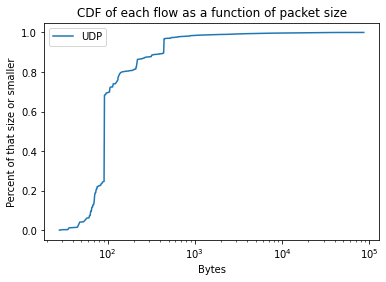

In [33]:
udp_cdf = pdf["UDP"].sort_index().cumsum() / pdf["UDP"].sort_index().sum()

plt.plot(udp_cdf.index, udp_cdf.values)
plt.xlabel('Bytes')
plt.ylabel('Percent of that size or smaller')
plt.title('CDF of each flow as a function of packet size')
plt.legend(["UDP"])
plt.xscale('log')  # Set x-axis to log scale
plt.show()

# 1.2 
The top 10 src prefixes (as counted by flow) are reported below. They account for 44.8% of all flows. The top 10 src prefixes (as counted by total bytes) are reborted above. These 10 flows account for 37.41% of total byte traffic.

```
Top 10 src prefixes:
 src_ip_prefix
184.105     1775
64.125      1852
212.83      2042
141.212     2143
94.23       2205
169.45      2494
163.53      2981
222.186     5269
169.54      9424
116.211    17019
Name: src_ip_prefix, dtype: int64
Top 10 src account for 44.80%

Top 10 src prefixes:
 src_ip_prefix
163.53     120920
5.8        126940
222.186    211068
169.45     229448
42.120     326122
128.112    506604
140.205    510833
116.211    680922
169.54     867928
212.83     928311
Name: Bytes, dtype: int64
Top 10 src account for 37.41%
```

In [16]:
# Extract the first two octets of the source IP address
grouped_flows = netflow_df.groupby('src_ip_prefix')

# Group by the source IP prefix and count the number of flows
flows_per_src_prefix = grouped_flows['src_ip_prefix'].count()
most_common_ten_prefixes = flows_per_src_prefix.sort_values()[-10:]
print(f"Top 10 src prefixes:\n", most_common_ten_prefixes)

# Get the top ten IP address prefixes and their percentage of all flows
percentage_src_flows = (most_common_ten_prefixes.sum() / flows_per_src_prefix.sum()) * 100
print(f"Top 10 src account for {percentage_src_flows:.2f}%")


# Group by percentage of bytes sent
bytes_per_prefix = grouped_flows['Bytes'].sum()
biggest_ten_prefixes = bytes_per_prefix.sort_values()[-10:]
print(f"\nTop 10 src prefixes:\n", biggest_ten_prefixes)

percentage_of_traffic = (biggest_ten_prefixes.sum() / bytes_per_prefix.sum()) * 100
print(f"Top 10 src account for {percentage_of_traffic:.2f}%")

Top 10 src prefixes:
 src_ip_prefix
184.105     1775
64.125      1852
212.83      2042
141.212     2143
94.23       2205
169.45      2494
163.53      2981
222.186     5269
169.54      9424
116.211    17019
Name: src_ip_prefix, dtype: int64
Top 10 src account for 44.80%

Top 10 src prefixes:
 src_ip_prefix
163.53     120920
5.8        126940
222.186    211068
169.45     229448
42.120     326122
128.112    506604
140.205    510833
116.211    680922
169.54     867928
212.83     928311
Name: Bytes, dtype: int64
Top 10 src account for 37.41%


# 1.3
I chose port 23, which is used for Telnet. It appears as src_port in 0.15% of flows, but dst_port=23 for 18.4% of flows.

In [17]:
# Analyze port number 0

count_by_src_port = netflow_df.groupby("Src port")["Src port"].count()
count_by_dest_port = netflow_df.groupby("Dst port")["Dst port"].count()

percent_with_src_23 = 100 * count_by_src_port[23] / count_by_src_port.sum()
percent_with_dest_23 = 100 * count_by_dest_port[23] / count_by_dest_port.sum()


print(f"Packets with src_port=23 account for {percent_with_src_23:.2f}% of flows")
print(f"Packets with dst_port=23 account for {percent_with_dest_23:.2f}% of flows")

Packets with src_port=23 account for 0.15% of flows
Packets with dst_port=23 account for 18.40% of flows


# 1.4
Packets with src_ip=128.112.0.0/16 account for 4.20% of bytes.
Packets with dst_ip=128.112.0.0/16 account for 95.95% of bytes.
Packets with both src and dest within router account for 0.84% of bytes.

Very little of the traffic is between hosts within the router's group. Traffic is largely in & out of the network. Interestingly, 95% of all bytes are headed into the router's network. More data coming in than leaving.

In [18]:
bytes_by_src = netflow_df.groupby('src_ip_prefix')["Bytes"].sum()
bytes_by_dst = netflow_df.groupby('dst_ip_prefix')["Bytes"].sum()

percent_bytes_from_router = 100 * bytes_by_src["128.112"] / bytes_by_src.sum()
print(f"Packets with src_ip=128.112.0.0/16 account for {percent_bytes_from_router:.2f}% of bytes")

percent_bytes_towards_router = 100 * bytes_by_dst["128.112"] / bytes_by_dst.sum()
print(f"Packets with dst_ip=128.112.0.0/16 account for {percent_bytes_towards_router:.2f}% of bytes")

incoming = netflow_df[netflow_df['dst_ip_prefix'] == "128.112"]
internal_flows = incoming[incoming['src_ip_prefix'] == "128.112"]

percent_bytes_within_router = 100 * (internal_flows["Bytes"].sum() / netflow_df["Bytes"].sum())
print(f"Packets with both src and dest within router account for {percent_bytes_within_router:.2f}% of bytes")

Packets with src_ip=128.112.0.0/16 account for 4.20% of bytes
Packets with dst_ip=128.112.0.0/16 account for 95.95% of bytes
Packets with both src and dest within router account for 0.84% of bytes


# 1.5
It does not change my answer to Q1.1. For Q1.2, I expect that the diversity of src IPs would increase. That is, the percentage of traffic accounted for by the top 10 src_ips would be less. For Q1.3, I would expect the telnet traffic in an internet Cafe to be smaller than a university. For Q1.4, I would expect the ratio of incoming/outgoing to be about the same, since most consumer bandwidth is spent downloading content.

In [19]:
routes_df = pd.read_csv('bgp_route.csv')
udpates_df = pd.read_csv('bgp_update.csv')
routes_df['ASPATH'] = routes_df['ASPATH'].str.split()

# 2.1
The top 10 ASs are reported below. So are the number of routes which they appear in. Country of origins are US, SE, MU, NO, EE, and CH. The majority are in the US. It may be innefficient to have packets travel into ASs located in the US when a packet from another continent has to make a round trip to the US and back.

3356: LEVEL3, US  
3257: GTT-BACKBONE GTT, US  
1299: TWELVE99 Arelion, fka Telia Carrier, SE  
6939: HURRICANE, US  
2914: NTT-LTD-2914, US  
174: COGENT-174, US  
37100: SEACOM-AS, MU  
49788: NEXTHOP, NO  
3130: RGNET-SEA RGnet Seattle Westin, EE  
3303: SWISSCOM Swisscom Switzerland Ltd, CH  

```
The top top ASs by word count are
 ['3356', '3257', '1299', '6939', '2914', '174', '37100', '49788', '3130', '3303']
3356 appears in 19.63% of routes
3257 appears in 15.46% of routes
1299 appears in 13.32% of routes
6939 appears in 11.60% of routes
2914 appears in 11.16% of routes
174 appears in 9.32% of routes
37100 appears in 9.33% of routes
49788 appears in 8.53% of routes
3130 appears in 7.85% of routes
3303 appears in 7.50% of routes
```

In [20]:
# Gotta count em all
word_counts = Counter(word for words_list in routes_df['ASPATH'] for word in words_list)

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index')
word_counts_df.columns = ['Count']
word_counts_df = word_counts_df.sort_values('Count', ascending=False)
top_ten = word_counts_df[:10].index.array.tolist()
print("The top top ASs by word count are\n", top_ten)

# Count occurences
counts = []
for asn in top_ten:
  counts.append(0)
  for route in routes_df["ASPATH"]:
    if asn in route:
      counts[-1] += 1

# Get percent
percent_appears = []
for i in range(0, len(top_ten)):
  percent_appears.append(100 * counts[i] / len(routes_df["ASPATH"]))

for word, percent_appears in zip(top_ten, percent_appears):
  print(f"{word} appears in {percent_appears:.2f}% of routes")

The top top ASs by word count are
 ['3356', '3257', '1299', '6939', '2914', '174', '37100', '49788', '3130', '3303']
3356 appears in 19.63% of routes
3257 appears in 15.46% of routes
1299 appears in 13.32% of routes
6939 appears in 11.60% of routes
2914 appears in 11.16% of routes
174 appears in 9.32% of routes
37100 appears in 9.33% of routes
49788 appears in 8.53% of routes
3130 appears in 7.85% of routes
3303 appears in 7.50% of routes


# 2.2
Plot of CDF is below. More than 95% of all ASPATHs had 6 or fewer unique ASs! This means that packets will travel through very few ASs during its journey across the internet.

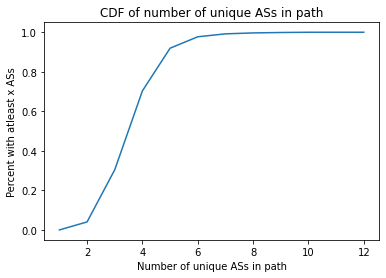

In [21]:
routes_df['path_lengths'] = routes_df['ASPATH'].apply(set).apply(len)
bins = routes_df.groupby('path_lengths')['path_lengths'].count().sort_index()
cdf = bins.cumsum() / bins.sum()

plt.plot(cdf)
plt.xlabel('Number of unique ASs in path')
plt.ylabel('Percent with atleast x ASs')
plt.title('CDF of number of unique ASs in path')
plt.show()

# 2.3
Plot is below. There are an average of 1124.64 updates per minute.

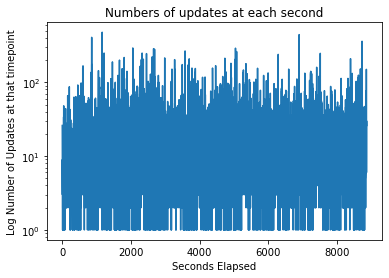

Average per minute:  1124.6381059751975


In [26]:
updates_by_second = udpates_df["TIME"].value_counts().sort_index()
plt.plot(updates_by_second.values.tolist())
plt.xlabel('Seconds Elapsed')
plt.ylabel('Log Number of Updates at that timepoint')
plt.yscale("log")
plt.title('Numbers of updates at each second')
plt.show()

print("Average per minute: ", 60 * updates_by_second.mean())

# 2.4
The CDF is shown below. The 99% percentile and up account for nearly all of the updates, which implies that 99% of ASs are relatively stable, while 1% announce new paths much more often.

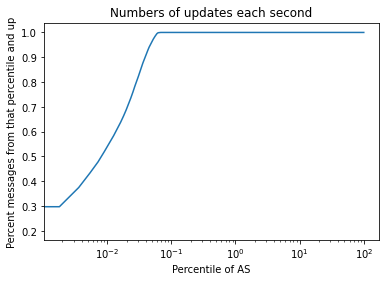

In [27]:
# Number of updates by AS
num_updates_per_as = udpates_df["FROM"].apply(lambda x: x.split(' ')[-1][2:]).value_counts()
all_asns = pd.Series(word_counts_df.index) # word_counts_df from earlier

# Find the number of updates for each AS, set the value to zero if AS not in num_updates_per_as
update_counts = dict()
for asn in all_asns:
  if asn in num_updates_per_as:
    update_counts[asn] = num_updates_per_as[asn]
  else:
    update_counts[asn] = 0

update_counts = pd.Series(update_counts).sort_values(ascending=False)
percentiles = update_counts.cumsum() / update_counts.sum()
percentiles = percentiles.reset_index(drop=True)

plt.plot(100 * percentiles.index / len(percentiles), percentiles.values)
plt.xlabel('Percentile of AS')
plt.ylabel('Percent messages from that percentile and up')
plt.xscale("log")
plt.title('Numbers of updates each second')
plt.show()